## Transformer Training

Alex McDonald

In this jupyter notebook we will load the vocab and examples, then train a transformer on the spam and phishing URL examples. We will be using the GLoVE pre-trained embeddings, mostly to cut down on the amount of training needed for the rest of the transformer. 

In [1]:
import torch, torch.nn as nn
import numpy as np
import pandas as pd
import nltk
import math
import matplotlib.pyplot as plt

In [2]:
#Load the vocabulary space, adapted from Homework 2
glove_file = "./datasets/glove.6B.100d.txt" #or 50d

embeddings_dict = {}

with open(glove_file, 'r', encoding='utf8') as f:
    for i, line in enumerate(f):
        if i == 0:
            print(line)
        line = line.strip().split(' ')
        word = line[0]
        embed = np.asarray(line[1:], "float")

        embeddings_dict[word] = embed

print('Loaded {} words from glove'.format(len(embeddings_dict)))

embedding_matrix = np.zeros((len(embeddings_dict)+2, 100)) #add 1 for padding

word2id = {}
for i, word in enumerate(embeddings_dict.keys()):

    word2id[word] = i                                #Map each word to an index
    embedding_matrix[i] = embeddings_dict[word]      #That index holds the Glove embedding in the embedding matrix

# Our joint vocabulary for both models / sanity check to see if we've loaded it correctly:
print(word2id['the'])
print(embedding_matrix[word2id['the']])

word2id['<pad>'] = embedding_matrix.shape[0] - 2
word2id['<start>'] = embedding_matrix.shape[0] - 1
print(embedding_matrix[word2id['<pad>']])

the -0.038194 -0.24487 0.72812 -0.39961 0.083172 0.043953 -0.39141 0.3344 -0.57545 0.087459 0.28787 -0.06731 0.30906 -0.26384 -0.13231 -0.20757 0.33395 -0.33848 -0.31743 -0.48336 0.1464 -0.37304 0.34577 0.052041 0.44946 -0.46971 0.02628 -0.54155 -0.15518 -0.14107 -0.039722 0.28277 0.14393 0.23464 -0.31021 0.086173 0.20397 0.52624 0.17164 -0.082378 -0.71787 -0.41531 0.20335 -0.12763 0.41367 0.55187 0.57908 -0.33477 -0.36559 -0.54857 -0.062892 0.26584 0.30205 0.99775 -0.80481 -3.0243 0.01254 -0.36942 2.2167 0.72201 -0.24978 0.92136 0.034514 0.46745 1.1079 -0.19358 -0.074575 0.23353 -0.052062 -0.22044 0.057162 -0.15806 -0.30798 -0.41625 0.37972 0.15006 -0.53212 -0.2055 -1.2526 0.071624 0.70565 0.49744 -0.42063 0.26148 -1.538 -0.30223 -0.073438 -0.28312 0.37104 -0.25217 0.016215 -0.017099 -0.38984 0.87424 -0.72569 -0.51058 -0.52028 -0.1459 0.8278 0.27062

Loaded 400000 words from glove
0
[-0.038194 -0.24487   0.72812  -0.39961   0.083172  0.043953 -0.39141
  0.3344   -0.57545   0.087459  0

For the URLs, we plan on pre-processing the string to split by characters such as "." or "/". We will likely need embeddings for things like ".com" or "https". First, we need to check if these embeddings already exist:

In [3]:
def embedding_exists(s):
    if not (s in word2id): return False
    if not (word2id[s] in embedding_matrix): return False
    return True

test_tokens = ["http", "https", ".com", "com", ".org", "org", ".net", "net"] #can add more, but likely that <unk> token will be frequent in the URL model
found = []
not_found = []
for token in test_tokens:
    if (embedding_exists(token)): 
        found.append(token)
    else: 
        not_found.append(token)

print("Found tokens %s" % found)
print("Could not find %s" % not_found)
        

Found tokens []
Could not find ['http', 'https', '.com', 'com', '.org', 'org', '.net', 'net']


It looks like there does not exist common url components in the Glove embeddings, so we will need to likely train our own embeddings for the URL model. This might give the model an advantage though, because patterns like "http" vs. "https" might help the model distinguish between different url types. Given how many different combinations of URLs can exist though (such as two words put together without any hyphenation) may still lead to a large number of $<unk>$ tokens, which will be another problem to address.

However, the GloVE embeddings should be adequate for the spam detection model. We will still need to be careful though, because the glove embeddings carry some amount of bias with them, which may become amplified by the model.

To save on computational resources, we will start with a smaller subset of the data, then increase it for the final training. Let's load the spam datasets:

In [60]:
spam_full = pd.read_csv("./datasets/SpamHam/train.csv", nrows=20000)

split_ratio = 0.8
train_size = int(split_ratio*spam_full.shape[0])
spam_train = spam_full.iloc[:train_size]
spam_valid = spam_full.iloc[train_size:]
max_length = 120 #inclusive of start token

from nltk import word_tokenize

start_id = word2id['<start>']

def tokenize_example(line):
    example = [start_id]
    tokenized = word_tokenize(line)
    i = 0
    for token in tokenized:
        if not (token in word2id): continue #not using <unk> for spam dataset
        i += 1
        if (i >= max_length): break
        example.append(word2id[token])
        
    #add padding
    padding = word2id["<pad>"]
    for i in range(max_length - len(example)):
        example.append(padding)
    return np.array(example)

def tokenize(df):
    examples = []
    for index, row in df.iterrows():
        example = tokenize_example(row["text"])
        if (len(example) > 0 and len(example.shape) > 0): examples.append((example, row["label"]))
    return examples

tokenized_spam_train = tokenize(spam_train)
tokenized_spam_valid = tokenize(spam_valid)

Here we will create a simple pytorch transformer. A major limitation is the amount of computational power and time that we have to be able to train it, so our model will be smaller than the typical transformer. However, we are not using it like a typical transformer either, because its output space is a simple 'yes' or 'no,' so it is unlikely to need many parameters to begin with. We will start with an encoder model, but if it performs poorly we can try a decoder model.

In [61]:
class TransformerModel(nn.Module):

    def __init__(self, embedding_matrix, model_size, n_heads, n_layers, hidden_size, embedding_dims=100):
        super().__init__()

        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix))
        self.pos_encoding = PositionalEncoding(embedding_dims, max_length)
        self.input_linear = nn.Linear(embedding_dims, model_size)
        encoder_layers = nn.TransformerEncoderLayer(model_size, n_heads, hidden_size, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layers, n_layers)
        #self.encoder = nn.Transformer(encoder_layers, n_layers, batch_first=True)
        self.output_hidden_1 = nn.Linear(model_size, hidden_size)
        self.relu = nn.ReLU()
        self.output_hidden_2 = nn.Linear(hidden_size, 2) #binary classification
        self.model_size = model_size


    def forward(self, input):

        #print("intput.shape: ", input.shape, len(input.shape))
        input = (self.embedding(input) * math.sqrt(self.model_size)) #recommended from documentation
        input = self.pos_encoding(input)
        #print("input after poe:", input.shape)

        input = self.input_linear(input) #get a representation that has the model size for the positionally encoded embeddings
        #print("after input linear: ", input.shape)
        
        output = self.encoder(input)[:,0] #take the last vector
        #print("after encoder: ", output.shape)
        output = self.output_hidden_1(output)

        output = self.relu(output)
        output = self.output_hidden_2(output)

        #print("after linear:", output.shape)

        return output

class PositionalEncoding(nn.Module):

    def __init__(self, model_size, max_len): #from torch documentation
        super().__init__()
        self.dropout = nn.Dropout(p=0.1)
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, model_size, 2) * (-math.log(10000.0) / model_size))
        pe = torch.zeros(max_len, 1, model_size)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

And here we will define the training loop:

--- Epoch 1 --- 
epoch: 0 batch: 11 loss: 0.848502117395401
epoch: 0 batch: 21 loss: 0.7151371598243713
epoch: 0 batch: 31 loss: 0.6793999373912811
epoch: 0 batch: 41 loss: 0.6126187473535538
epoch: 0 batch: 51 loss: 0.6822302162647247
epoch: 0 batch: 61 loss: 0.6528470039367675
epoch: 0 batch: 71 loss: 0.5675625175237655
epoch: 0 batch: 81 loss: 0.6364831149578094
epoch: 0 batch: 91 loss: 0.5843800485134125
epoch: 0 batch: 101 loss: 0.5841830223798752
epoch: 0 batch: 111 loss: 0.6015588223934174
epoch: 0 batch: 121 loss: 0.6720779061317443
epoch: 0 batch: 131 loss: 0.6825878858566284
epoch: 0 batch: 141 loss: 0.6762398779392242
epoch: 0 batch: 151 loss: 0.6801296591758728
epoch: 0 batch: 161 loss: 0.6701814413070679
epoch: 0 batch: 171 loss: 0.6745322585105896
epoch: 0 batch: 181 loss: 0.6894187688827514
epoch: 0 batch: 191 loss: 0.6266108989715576
epoch: 0 batch: 201 loss: 0.60992032289505
epoch: 0 batch: 211 loss: 0.5508355736732483
epoch: 0 batch: 221 loss: 0.5572069317102433
epoch

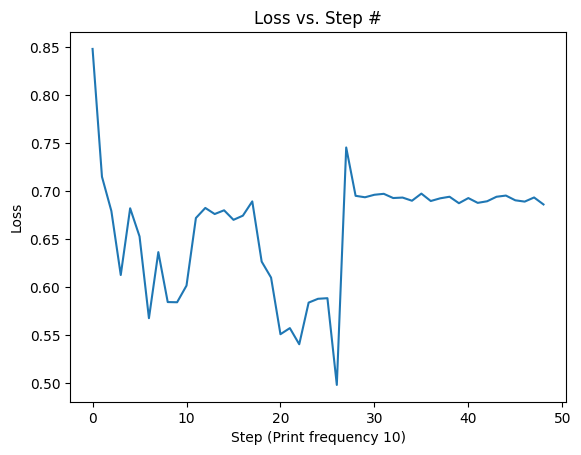

In [62]:

spam_model = TransformerModel(embedding_matrix, model_size=60, n_heads=20, n_layers=4, hidden_size=60)

import traceback
criteria = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(spam_model.parameters(), lr=0.005)

epochs = 1
batch_size = 32
print_frequency = 10

spam_train_dataloader = torch.utils.data.DataLoader(tokenized_spam_train, batch_size=batch_size)

one_hot = torch.tensor(np.array([[1, 0], [0, 1]]), dtype=torch.float)

losses = []
for i in range(epochs):
    print("--- Epoch %s --- " % (i+1))

    spam_model.train()
    avg_loss = 0

    for step, data in enumerate(spam_train_dataloader):
        x,y = data
        x = x.squeeze()
        if (len(x.shape) == 0): continue
        optimizer.zero_grad()

        output = spam_model(x)
        #print("output:", output)
        #print("y:", one_hot[y])
        #print("output shape:", output.shape)
        #print("y.shape:", y.shape)
        loss = criteria(output, one_hot[y])

        loss.backward()
        optimizer.step()

        avg_loss += loss.item()

        if step % print_frequency == 1 and step > 1:
            if (step > 1): losses.append(avg_loss / print_frequency)
            #print(output, one_hot[y])
            print('epoch: {} batch: {} loss: {}'.format(
                i,
                step,
                avg_loss / print_frequency
            ))
            avg_loss = 0

plt.plot(losses)
plt.xlabel("Step (Print frequency %s)" % print_frequency)
plt.ylabel("Loss")
plt.title("Loss vs. Step #")
plt.show()

In [63]:
#From Homework 3:
def predict(model, valid_dataloader):

    model.eval()
    
    sigmoid = nn.Sigmoid()

    total_examples = 0 #len(valid_dataloader.dataset)
    total_positive = 0
    total_negative = 0

    true_positive = 0
    false_positive = 0
    true_negative = 0
    false_negative = 0

    for x, y in valid_dataloader:
        x = x.squeeze()
        if (len(x.shape) == 0): continue
        output = model(x)
        
        #print(output, y)
        if (total_examples > 1000): break

        total_examples += output.shape[0]
        for i in range(output.shape[0]):
            if (output[i][0].item() >= 0.5):
                if (y[0].item() == 0):
                    true_negative += 1
                    total_negative += 1
                else:
                    false_negative += 1
                    total_positive += 1
            else:
                if (y[0].item() == 0):
                    false_positive += 1
                    total_negative += 1
                else:
                    true_positive += 1
                    total_positive += 1
        #print("total examples:", total_examples, "; T+:", true_positive, "; F+:", false_positive, "; T-:", true_negative, "; F-:", false_negative)

    accuracy = (true_positive + true_negative) / total_examples
    print('\naccuracy: %s/%s = %s' % (true_positive+true_negative, total_examples, (true_positive + true_negative) / total_examples))
    print('True positive: %s' % (true_positive/total_examples))
    print("False positive: %s" % (false_positive/total_examples))
    print('True negative: %s' % (true_negative/total_examples))
    print("False negative: %s" % (false_negative/total_examples))
    return accuracy

In [64]:
spam_valid_dataloader = torch.utils.data.DataLoader(tokenized_spam_valid, batch_size=batch_size)
predict(spam_model, spam_valid_dataloader)


accuracy: 480/1024 = 0.46875
True positive: 0.46875
False positive: 0.53125
True negative: 0.0
False negative: 0.0


0.46875